In [ ]:
from google.colab import drive

!pip install pymupdf
!pip install transformers pymupdf --quiet

import os
import re
import fitz  # PyMuPDF
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 103.4 MB/s eta 0:00:00


Funções

In [ ]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text() + " "
    return full_text

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-z0-9,.;:()\- ]", "", text)
    return text.strip()

def extract_label(text):
    text = text.lower()

    # Prioridade para BI-RADS explícito
    if "bi-rads" in text or "categoria" in text:
        if any(cat in text for cat in ["categoria 4", "categoria 5", "categoria 6"]):
            return 1  # Provável câncer
        elif any(cat in text for cat in ["categoria 1", "categoria 2"]):
            return 0  # Normal ou benigno

    # Palavras-chave secundárias (caso não tenha categoria)
    if any(term in text for term in ["câncer", "cancer", "tumor", "maligno", "carcinoma"]):
        return 1

    return 0


def png_to_tensor_3ch(png_path):
    pil_img = Image.open(png_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    return transform(pil_img)

Dataset multimodal

In [ ]:
class MammographyMultiImageDataset(Dataset):
    def __init__(self, image_dir, pdf_dir, tokenizer, max_length=128):
        self.image_dir = image_dir
        self.pdf_dir = pdf_dir
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.pdf_texts = {}
        self.pdf_labels = {}
        self.samples = []

        pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
        for pdf_file in pdf_files:
            prefix = pdf_file[:-4]
            pdf_path = os.path.join(pdf_dir, pdf_file)
            text = extract_text_from_pdf(pdf_path)
            clean = clean_text(text)
            label = extract_label(clean)
            self.pdf_texts[prefix] = clean
            self.pdf_labels[prefix] = label

            imgs = [f for f in os.listdir(image_dir) if f.startswith(prefix+"_") and f.endswith(".png")]
            for img in imgs:
                img_path = os.path.join(image_dir, img)
                self.samples.append((img_path, clean, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, text, label = self.samples[idx]
        img_tensor = png_to_tensor_3ch(img_path)
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "image": img_tensor,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

Modelo multimodal simples (CNN + BERT)

In [ ]:
class MultiModalClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", image_model_name="resnet18", num_classes=2):
        super().__init__()
        # Texto (BERT)
        self.text_model = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_model.config.hidden_size

        # Imagem (ResNet)
        self.image_model = models.resnet18(pretrained=True)
        num_ftrs = self.image_model.fc.in_features
        self.image_model.fc = nn.Identity()
        image_feat_size = num_ftrs

        # Classificador final
        self.classifier = nn.Sequential(
            nn.Linear(text_hidden_size + image_feat_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, images):
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output  # [batch, hidden_size]

        image_embeds = self.image_model(images)  # [batch, feat_size]

        combined = torch.cat((text_embeds, image_embeds), dim=1)
        out = self.classifier(combined)
        return out

Preparar tokenizer e dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Diretórios atualizados
train_image_dir = "/content/drive/MyDrive/imgCeonc/train/images"
train_pdf_dir = "/content/drive/MyDrive/imgCeonc/train/reports"

val_image_dir = "/content/drive/MyDrive/imgCeonc/valid/images"
val_pdf_dir = "/content/drive/MyDrive/imgCeonc/valid/reports"

# Criar datasets separados
train_dataset = MammographyMultiImageDataset(train_image_dir, train_pdf_dir, tokenizer)
val_dataset = MammographyMultiImageDataset(val_image_dir, val_pdf_dir, tokenizer)

# Criar dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Treinamento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalClassifier()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    for batch in dataloader:
        optimizer.zero_grad()

        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


Loop de treino

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    print(f" Val   loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

Epoch 1/5
 Train loss: 0.0680, accuracy: 0.9878
 Val   loss: 0.0796, accuracy: 0.9882
Epoch 2/5
 Train loss: 0.0669, accuracy: 0.9887
 Val   loss: 0.0761, accuracy: 0.9882
Epoch 3/5
 Train loss: 0.0634, accuracy: 0.9888
 Val   loss: 0.0757, accuracy: 0.9882
Epoch 4/5
 Train loss: 0.0628, accuracy: 0.9888
 Val   loss: 0.0679, accuracy: 0.9882
Epoch 5/5
 Train loss: 0.0600, accuracy: 0.9888
 Val   loss: 0.0729, accuracy: 0.9882


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds


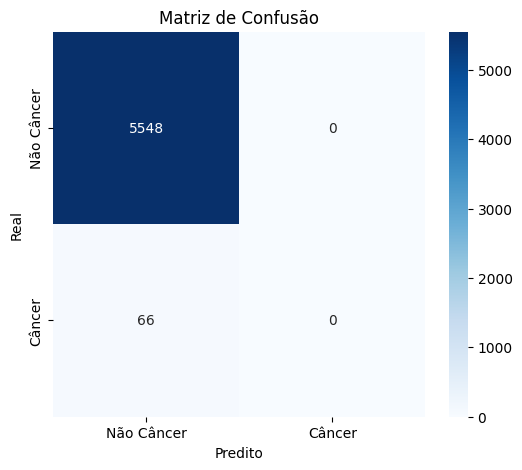

In [ ]:
true_labels, predicted_labels = get_predictions(model, val_loader)

# Matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)

# Exibir matriz
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Não Câncer", "Câncer"], yticklabels=["Não Câncer", "Câncer"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=["Não Câncer", "Câncer"]))

              precision    recall  f1-score   support

  Não Câncer       0.99      1.00      0.99      5548
      Câncer       0.00      0.00      0.00        66

    accuracy                           0.99      5614
   macro avg       0.49      0.50      0.50      5614
weighted avg       0.98      0.99      0.98      5614



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
